# Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [2]:
X_1 = pd.read_csv('training_data/feature_1_cleaned.csv', index_col='id')
X_2 = pd.read_csv('training_data/feature_2_cleaned.csv', index_col='id')
sensitivity = pd.read_csv('training_data/coupon_sensitivity.csv', index_col='id')
y = pd.read_csv('training_data/target_cleaned.csv', index_col='id')

In [3]:
common_index = set(X_1.index).intersection(set(y.index))
common_index = common_index.intersection(set(X_2.index))
common_index = common_index.intersection(set(sensitivity.index))

for row in sensitivity.index:
    if row not in common_index:
        sensitivity.drop(row, axis=0, inplace=True)
        
print(X_1.shape)
print(X_2.shape)
print(y.shape)
print(sensitivity.shape)

(14422, 4)
(14422, 10)
(14422, 8)
(14422, 8)


## Visualization

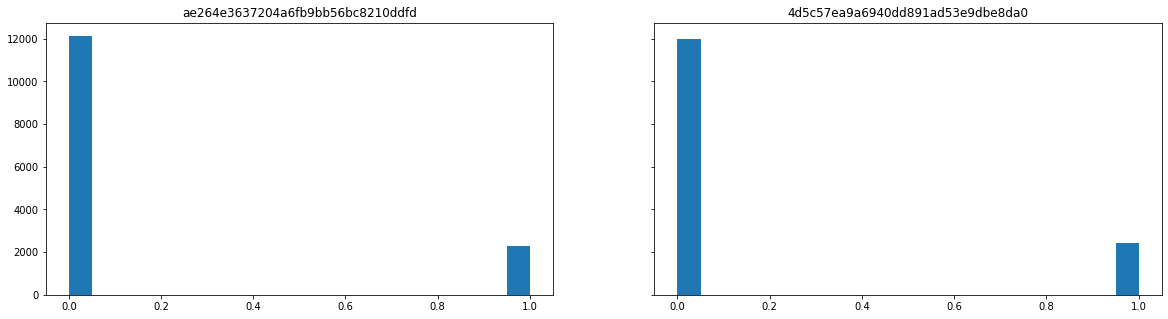

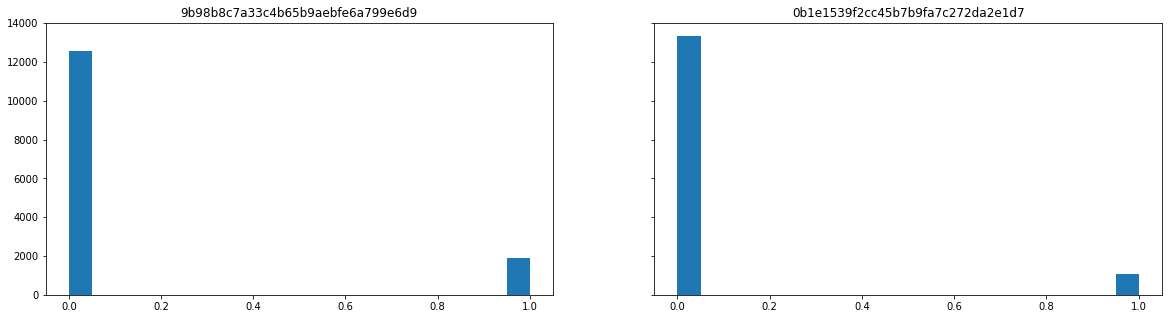

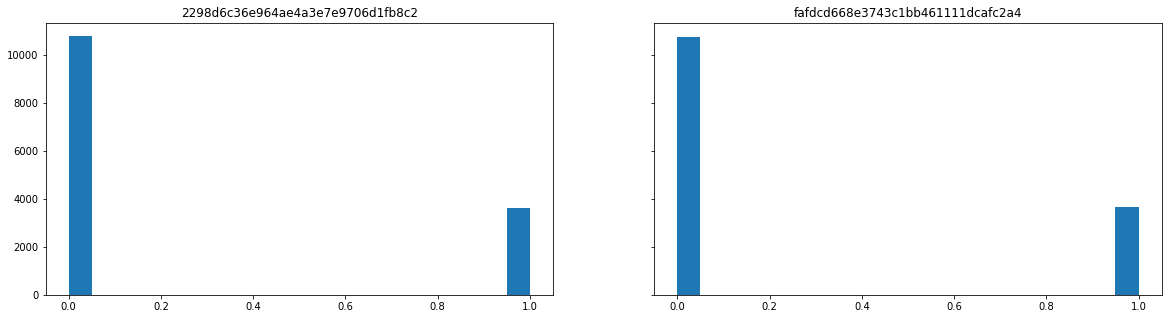

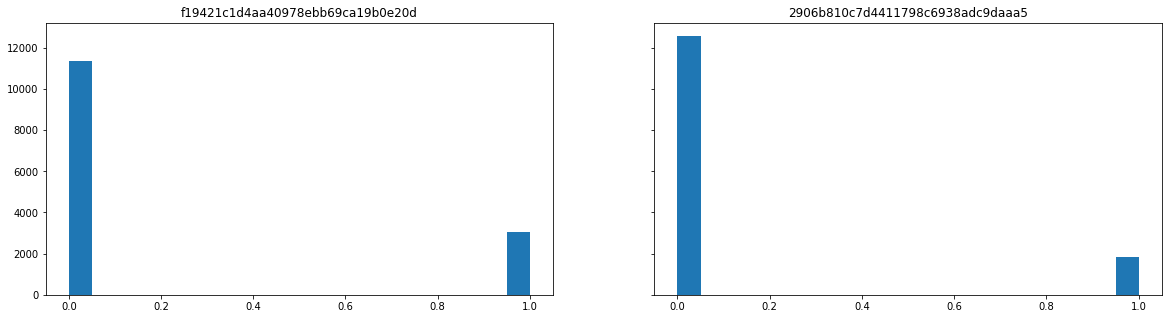

In [4]:
feature_df = y

for i in range(0, len(feature_df.columns), 2) :
    n_bins = 20
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,5))
    
    x = feature_df[feature_df.columns[i]]
    axs[0].hist(x, bins=n_bins)
    axs[0].set_title(feature_df.columns[i])

    if i+1 < len(feature_df.columns):
        _y = feature_df[feature_df.columns[i+1]]
        axs[1].hist(_y, bins=n_bins)
        axs[1].set_title(feature_df.columns[i+1])

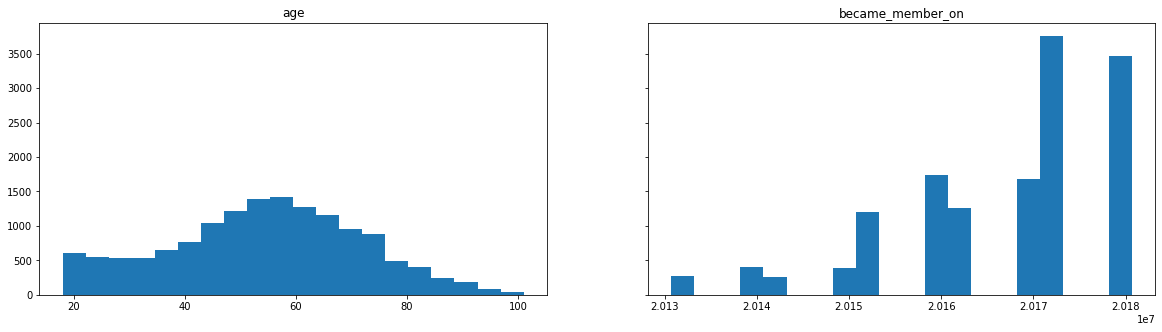

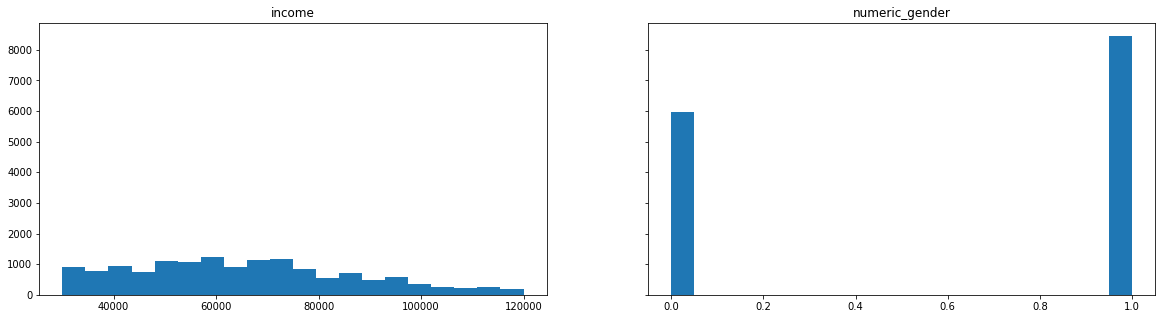

In [5]:
feature_df = X_1

for i in range(0, len(feature_df.columns), 2) :
    n_bins = 20
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,5))
    
    x = feature_df[feature_df.columns[i]]
    axs[0].hist(x, bins=n_bins)
    axs[0].set_title(feature_df.columns[i])

    if i+1 < len(feature_df.columns):
        _y = feature_df[feature_df.columns[i+1]]
        axs[1].hist(_y, bins=n_bins)
        axs[1].set_title(feature_df.columns[i+1])

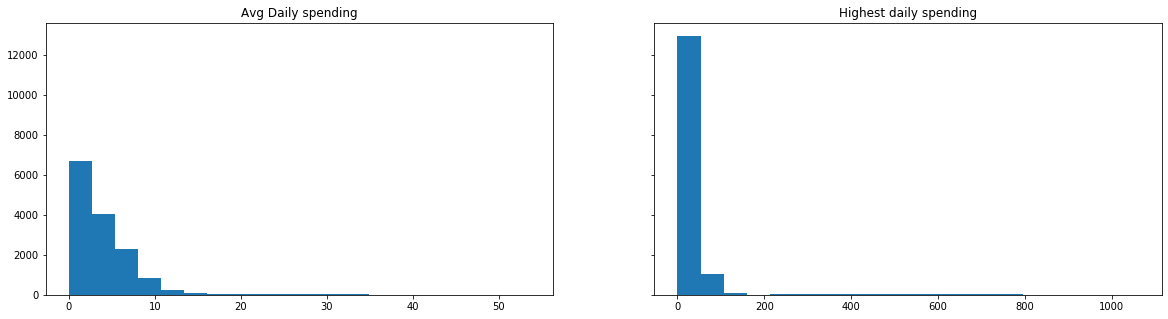

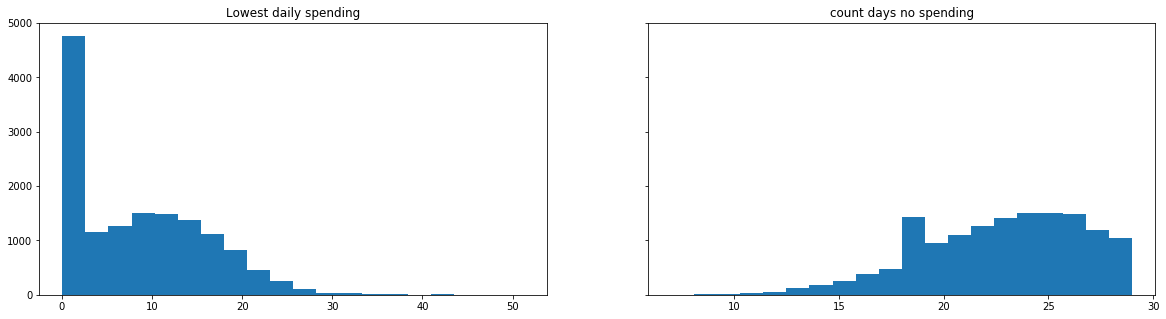

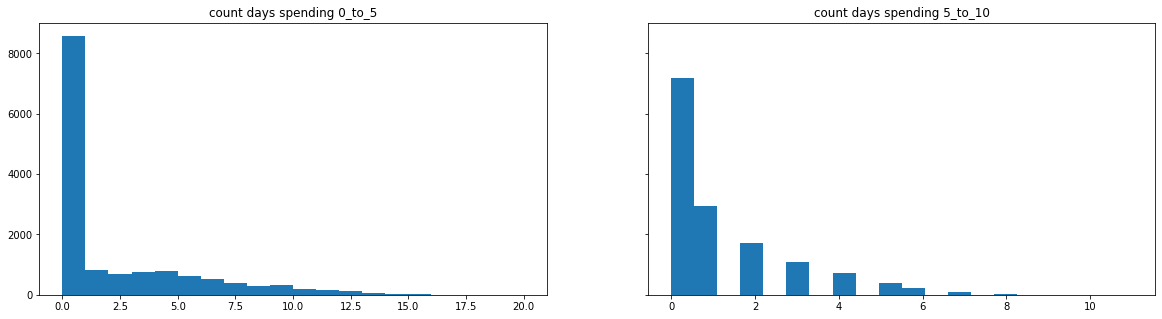

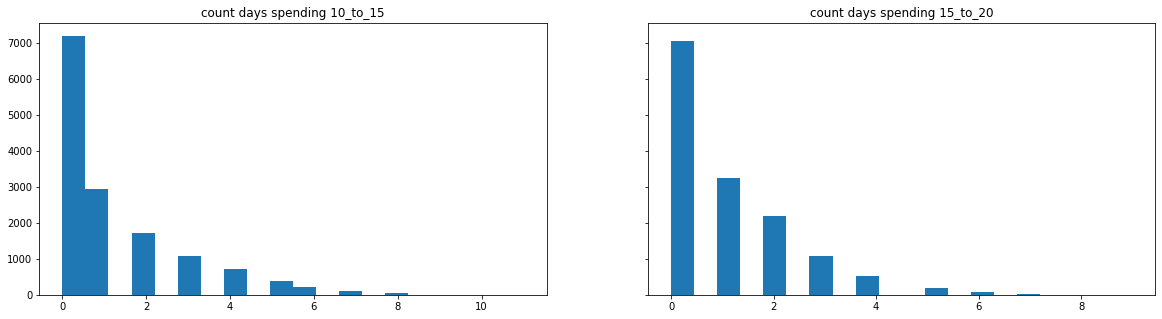

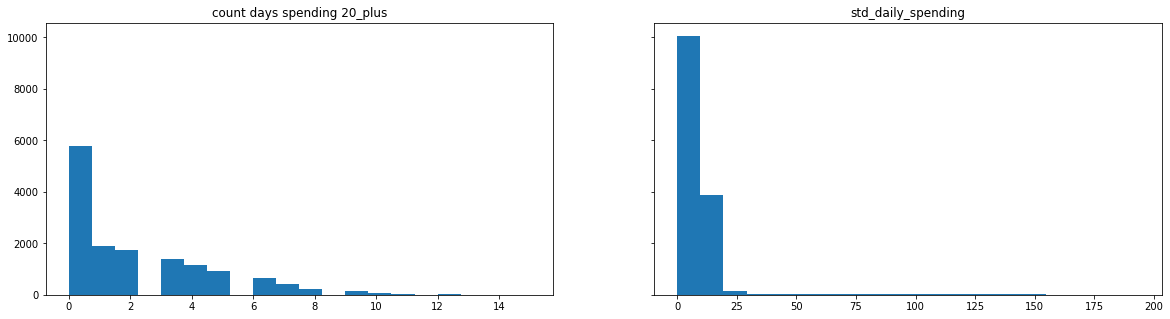

In [6]:
feature_df = X_2

for i in range(0, len(feature_df.columns), 2) :
    n_bins = 20
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,5))
    
    x = feature_df[feature_df.columns[i]]
    axs[0].hist(x, bins=n_bins)
    axs[0].set_title(feature_df.columns[i])

    if i+1 < len(feature_df.columns):
        _y = feature_df[feature_df.columns[i+1]]
        axs[1].hist(_y, bins=n_bins)
        axs[1].set_title(feature_df.columns[i+1])

## TODO: Longest consective spending

## Modeling Feature Group 1

In [7]:
y.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
id,,,,,,,,
7366bef4c288476dab78b09a33d0e692,0,1,0,0,0,0,0,0
b912b714bf5e40609f6ff25a9a542a9c,0,0,0,0,0,1,0,0
46b3c686bbbd4495940b4da488e10ed6,1,1,0,0,1,0,0,0
a14d4f2ec359464f8d4aeac17b755903,1,0,0,0,1,1,0,0
f37d9566b54547d8bdc64cc949ddab90,0,0,0,0,1,0,0,0


In [8]:
#X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1.values, y['ae264e3637204a6fb9bb56bc8210ddfd'].values, test_size=0.30, random_state=13)

In [9]:
X = pd.concat((X_1, X_2, sensitivity), axis=1)

columns = X.columns

X = preprocessing.scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

/Users/lileo/Documents/projects/starbucks_ml/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


/Users/lileo/Documents/projects/starbucks_ml/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


coupon ae264e3637204a6fb9bb56bc8210ddfd
roc_auc score is 0.5051997869237489
accuracy score is 0.8138648180242635
recall score is 0.06150341685649203
precision score is 0.17763157894736842
f1 score is 0.09137055837563453
---------------------------------------------------------------


/Users/lileo/Documents/projects/starbucks_ml/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


coupon 4d5c57ea9a6940dd891ad53e9dbe8da0
roc_auc score is 0.5012926281361916
accuracy score is 0.7948006932409012
recall score is 0.05725971370143149
precision score is 0.1761006289308176
f1 score is 0.08641975308641976
---------------------------------------------------------------


/Users/lileo/Documents/projects/starbucks_ml/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


coupon 9b98b8c7a33c4b65b9aebfe6a799e6d9
roc_auc score is 0.49847706043563317
accuracy score is 0.8426343154246101
recall score is 0.02544529262086514
precision score is 0.12345679012345678
f1 score is 0.04219409282700421
---------------------------------------------------------------


/Users/lileo/Documents/projects/starbucks_ml/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


coupon 0b1e1539f2cc45b7b9fa7c272da2e1d7
roc_auc score is 0.49925435878479507
accuracy score is 0.923050259965338
recall score is 0.0048543689320388345
precision score is 0.05555555555555555
f1 score is 0.008928571428571428
---------------------------------------------------------------


/Users/lileo/Documents/projects/starbucks_ml/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


coupon 2298d6c36e964ae4a3e7e9706d1fb8c2
roc_auc score is 0.49579953740750343
accuracy score is 0.6741767764298093
recall score is 0.12583668005354753
precision score is 0.24671916010498687
f1 score is 0.16666666666666669
---------------------------------------------------------------


/Users/lileo/Documents/projects/starbucks_ml/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


coupon fafdcd668e3743c1bb461111dcafc2a4
roc_auc score is 0.5055630531083323
accuracy score is 0.6849220103986136
recall score is 0.12813738441215325
precision score is 0.28034682080924855
f1 score is 0.1758839528558477
---------------------------------------------------------------


/Users/lileo/Documents/projects/starbucks_ml/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


coupon f19421c1d4aa40978ebb69ca19b0e20d
roc_auc score is 0.5063856536916994
accuracy score is 0.7365684575389948
recall score is 0.09872611464968153
precision score is 0.2421875
f1 score is 0.1402714932126697
---------------------------------------------------------------


/Users/lileo/Documents/projects/starbucks_ml/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


coupon 2906b810c7d4411798c6938adc9daaa5
roc_auc score is 0.4931222252363718
accuracy score is 0.8488734835355286
recall score is 0.019498607242339833
precision score is 0.07692307692307693
f1 score is 0.031111111111111114
---------------------------------------------------------------


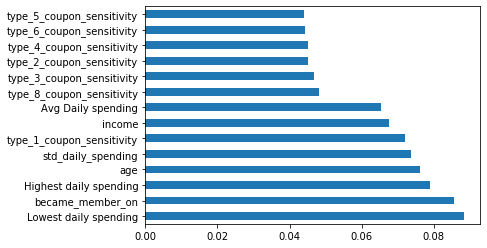

In [11]:
for coupon in y_train.columns:

    clf = RandomForestClassifier(
                                 random_state=11,
                                 min_samples_split=10,
                                 class_weight='balanced'
                                )
    clf.fit(X_train, y_train.loc[:][coupon])  

    feat_importances = pd.Series(clf.feature_importances_, index=columns)
    feat_importances.nlargest(14).plot(kind='barh')
    y_pred = clf.predict(X_test)
    print(f'coupon {coupon}')
    print(f'roc_auc score is {roc_auc_score(y_test.loc[:][coupon], y_pred)}')
    print(f'accuracy score is {accuracy_score(y_test.loc[:][coupon], y_pred)}')
    print(f'recall score is {recall_score(y_test.loc[:][coupon], y_pred)}')
    print(f'precision score is {precision_score(y_test.loc[:][coupon], y_pred)}')
    print(f'f1 score is {f1_score(y_test.loc[:][coupon], y_pred)}')
    print('---------------------------------------------------------------')

## Test with CNN

In [17]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
    
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(22,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

# different dropoff rate, 

# automl from h2o
 
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', auc])
    
for coupon in y_train.columns:
    model.fit(X_train, y_train[coupon], epochs=200, batch_size=2)

    _, _, test_acc = model.evaluate(X_test, y_test[coupon])
    print('Test accuracy:', test_acc)

Train on 11537 samples
Epoch 1/200
11537/11537 [==============================] - 6s 484us/sample - loss: 0.4565 - acc: 0.8337 - auc: 0.5034
Epoch 2/200
11537/11537 [==============================] - 5s 471us/sample - loss: 0.4448 - acc: 0.8394 - auc: 0.4928
Epoch 3/200
11537/11537 [==============================] - 5s 467us/sample - loss: 0.4434 - acc: 0.8395 - auc: 0.4958
Epoch 4/200
11537/11537 [==============================] - 5s 474us/sample - loss: 0.4424 - acc: 0.8395 - auc: 0.4989
Epoch 5/200
11537/11537 [==============================] - 5s 469us/sample - loss: 0.4423 - acc: 0.8395 - auc: 0.5042
Epoch 6/200
11537/11537 [==============================] - 5s 469us/sample - loss: 0.4412 - acc: 0.8395 - auc: 0.5056
Epoch 7/200
11537/11537 [==============================] - 6s 485us/sample - loss: 0.4414 - acc: 0.8395 - auc: 0.5079
Epoch 8/200
11537/11537 [==============================] - 5s 474us/sample - loss: 0.4413 - acc: 0.8395 - auc: 0.5099
Epoch 9/200
11537/11537 [========

In [24]:
from sklearn.neighbors import KNeighborsClassifier

for coupon in y_train.columns:

    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train.loc[:][coupon])  

#     print('roc_auc score:', clf.score(X_test_1, y_test_1.loc[:][coupon]))
    y_pred = clf.predict(X_test)
    print(f'coupon {coupon}')
    print(f'roc_auc score is {roc_auc_score(y_test.loc[:][coupon], y_pred)}')
    print(f'accuracy score is {accuracy_score(y_test.loc[:][coupon], y_pred)}')
    print(f'recall score is {recall_score(y_test.loc[:][coupon], y_pred)}')
    print(f'precision score is {precision_score(y_test.loc[:][coupon], y_pred)}')
    print(f'f1 score is {f1_score(y_test_1.loc[:][coupon], y_pred)}')
    print('---------------------------------------------------------------')

coupon ae264e3637204a6fb9bb56bc8210ddfd
roc_auc score is 0.49541578738566244
accuracy score is 0.8273830155979203
recall score is 0.018223234624145785
precision score is 0.10666666666666667
f1 score is 0.0311284046692607
---------------------------------------------------------------
coupon 4d5c57ea9a6940dd891ad53e9dbe8da0
roc_auc score is 0.4978082079539519
accuracy score is 0.8065857885615252
recall score is 0.03067484662576687
precision score is 0.15151515151515152
f1 score is 0.05102040816326531
---------------------------------------------------------------
coupon 9b98b8c7a33c4b65b9aebfe6a799e6d9
roc_auc score is 0.5055679446493411
accuracy score is 0.8530329289428076
recall score is 0.027989821882951654
precision score is 0.20754716981132076
f1 score is 0.04932735426008968
---------------------------------------------------------------
coupon 0b1e1539f2cc45b7b9fa7c272da2e1d7
roc_auc score is 0.4992534527808884
accuracy score is 0.9272097053726169
recall score is 0.0
precision sco

## Questions:

1. Are these features good enough?
2. Represent trend
3. Hyperopt

## HyperOpts

In [ ]:
X = pd.concat((X_1, X_2), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.20, random_state=10)

In [ ]:
y_train[:, 0]

In [ ]:
from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing
from hyperopt import tpe
import numpy as np

In [ ]:
from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing
from hyperopt import tpe
import numpy as np

# Instantiate a HyperoptEstimator with the search space and number of evaluations

# auc score, recall, f1
estim = HyperoptEstimator(classifier=gradient_boosting('gradient_boosting'),
                          preprocessing=[],
                          algo=tpe.suggest,
                          max_evals=40,
                          trial_timeout=120)

# Search the hyperparameter space based on the data

estim.fit(X_train, y_train[:, 0])

In [ ]:
print(estim.score(X_test, y_test[:, 0]))

In [ ]:
## island and gap